# Sentiment Analysis of English Premier League

# Data Collection

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
from PIL import Image
from datetime import datetime as dt
import nest_asyncio
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
from wordcloud import WordCloud
%matplotlib inline


analyzer = SentimentIntensityAnalyzer()
nest_asyncio.apply()

C:\Users\anizy\AppData\Local\Temp\ipykernel_18088\783396485.py:10: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [ ]:
#if you have developer access to pull data from twitter follow the below code to extract the data after setting env variables for key and secret, I have used a altered datset from kaggle
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

search_query = "f1 2022 car"
lang = "en"

tweets = tweepy.Cursor(api.search, q=search_query, lang=lang).items()

# Save tweets to a CSV file
csv_file = open('F1_tweets.csv', 'w', encoding='utf-8', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["Tweet", "Username", "Date"])

for tweet in tweets:
    csv_writer.writerow([tweet.text, tweet.user.screen_name, tweet.created_at])

csv_file.close()

In [17]:
# store in a pandas dataframe
#datset has been modified to have only the recent tweets
df_main = pd.read_csv("EPL_tweets.csv")
df = df_main #to avoid re-reading data in case of issues, once finalised this can be removed
#ignore warning as the dataset will be cleaned after exploration

In [18]:
df.head()

,date,file_name,followers,friends,group_name,location,retweet_count,screenname,search_query,text,twitter_id,username,polarity,partition_0,partition_1
0,09/07/2020 11:34,Liverpool,697325,594,Liverpool FC,Liverpool,0,LivEchoLFC,#liverpoolfc OR #YNWA OR #LFC,This is a strange claim #LFC https://t.co/U1...,1.281190e+18,Liverpool FC News,-0.2023,EPL,Liverpool
1,09/07/2020 11:33,Liverpool,2348,2907,Liverpool FC,Huyton,65,ged11lfc,#liverpoolfc OR #YNWA OR #LFC,RT @TheKopiteOFF: 😱| #LFC have won 30 of their...,1.281190e+18,Ged Smith,0.8316,EPL,Liverpool
2,09/07/2020 11:33,Liverpool,465,177,Liverpool FC,"Accra, Ghana",32,calvin_winzy,#liverpoolfc OR #YNWA OR #LFC,RT @SkySportsPL: 🔴 - #LFC secure first away wi...,1.281190e+18,DADA BA♐,0.8793,EPL,Liverpool
3,09/07/2020 11:33,Liverpool,334,1524,Liverpool FC,NaN,0,Rurs1,#liverpoolfc OR #YNWA OR #LFC,Outrageous... Poor auld Martin Tyler has to ju...,1.281190e+18,Ruairi Nolan,-0.6808,EPL,Liverpool
4,09/07/2020 11:33,Liverpool,760,1264,Liverpool FC,"Kildare, Ireland 🇮🇪",176,LSHighVoltage,#liverpoolfc OR #YNWA OR #LFC,RT @TheRedmenTV: ✅ Won the league ✅ Fastest te...,1.281190e+18,🇮🇪 David D'Arcy 🇮🇪,0.8176,EPL,Liverpool


In [19]:
df["text"]

0         This is a strange claim  #LFC  https://t.co/U1...
1         RT @TheKopiteOFF: 😱| #LFC have won 30 of their...
2         RT @SkySportsPL: 🔴 - #LFC secure first away wi...
3         Outrageous... Poor auld Martin Tyler has to ju...
4         RT @TheRedmenTV: ✅ Won the league ✅ Fastest te...
                                ...                        
799235    I honestly don't understand &amp; think it's d...
799236    Fantastically positioned in highly sought afte...
799237    @SkySportsNews Not a bad player tbh hope #Sout...
799238    Now is official! Pierre-Emile #Højbjerg to #To...
799239    As expected, #Hojbjerg’s arrival at #thfc is a...
Name: text, Length: 799240, dtype: object

# Exploratory Data Analysis 

In [20]:
# set columns that are useful for model
used_col = [ 'date',  'text']
df = df[used_col]

In [21]:
df.head()

,date,text
0,09/07/2020 11:34,This is a strange claim #LFC https://t.co/U1...
1,09/07/2020 11:33,RT @TheKopiteOFF: 😱| #LFC have won 30 of their...
2,09/07/2020 11:33,RT @SkySportsPL: 🔴 - #LFC secure first away wi...
3,09/07/2020 11:33,Outrageous... Poor auld Martin Tyler has to ju...
4,09/07/2020 11:33,RT @TheRedmenTV: ✅ Won the league ✅ Fastest te...


In [22]:
df.isnull().sum()

date    0
text    0
dtype: int64

In [23]:
df.duplicated().sum()

158519

In [24]:
df.count()

date    799240
text    799240
dtype: int64

# Data Pre-Processing

In [10]:
# check basic info on dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799240 entries, 0 to 799239
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    799240 non-null  object
 1   text    799240 non-null  object
dtypes: object(2)
memory usage: 12.2+ MB


In [25]:
# drop some duplicate tweets 
df.drop_duplicates(subset = "text")

,date,text
0,09/07/2020 11:34,This is a strange claim #LFC https://t.co/U1...
1,09/07/2020 11:33,RT @TheKopiteOFF: 😱| #LFC have won 30 of their...
2,09/07/2020 11:33,RT @SkySportsPL: 🔴 - #LFC secure first away wi...
3,09/07/2020 11:33,Outrageous... Poor auld Martin Tyler has to ju...
4,09/07/2020 11:33,RT @TheRedmenTV: ✅ Won the league ✅ Fastest te...
...,...,...
799227,11/08/2020 17:24,We're big fans of high ropes courses. Here's t...
799234,11/08/2020 17:16,// Get your orders in // Sabro is your new bes...
799235,11/08/2020 17:16,I honestly don't understand &amp; think it's d...
799236,11/08/2020 17:15,Fantastically positioned in highly sought afte...


In [26]:
df.shape

(799240, 2)

In [27]:
df.describe()

,date,text
count,799240,799240
unique,93189,460499
top,05/08/2020 20:16,RT @MDfineart: Ship and ice creams at Mayflowe...
freq,522,2486


In [28]:
df["text"].describe()

count                                                799240
unique                                               460499
top       RT @MDfineart: Ship and ice creams at Mayflowe...
freq                                                   2486
Name: text, dtype: object

In [29]:
df["date"].describe()

count               799240
unique               93189
top       05/08/2020 20:16
freq                   522
Name: date, dtype: object

In [30]:
df.head()

,date,text
0,09/07/2020 11:34,This is a strange claim #LFC https://t.co/U1...
1,09/07/2020 11:33,RT @TheKopiteOFF: 😱| #LFC have won 30 of their...
2,09/07/2020 11:33,RT @SkySportsPL: 🔴 - #LFC secure first away wi...
3,09/07/2020 11:33,Outrageous... Poor auld Martin Tyler has to ju...
4,09/07/2020 11:33,RT @TheRedmenTV: ✅ Won the league ✅ Fastest te...


In [33]:
df.shape

(799240, 2)

In [34]:
# generate sentiment scores per tweet
sentiment_score = df["text"].apply(lambda x: analyzer.polarity_scores(x))

# add sentiment score to dataframe
df = pd.concat([df, sentiment_score.apply(pd.Series)],1)

C:\Users\anizy\AppData\Local\Temp\ipykernel_18088\354690231.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat([df, sentiment_score.apply(pd.Series)],1)


In [35]:
df.head()

,date,text,neg,neu,pos,compound
0,2020-09-07 11:34:00,This is a strange claim #LFC https://t.co/U1...,0.231,0.769,0.000,-0.2023
1,2020-09-07 11:33:00,RT @TheKopiteOFF: 😱| #LFC have won 30 of their...,0.143,0.640,0.217,0.4588
2,2020-09-07 11:33:00,RT @SkySportsPL: 🔴 - #LFC secure first away wi...,0.058,0.621,0.321,0.8793
3,2020-09-07 11:33:00,Outrageous... Poor auld Martin Tyler has to ju...,0.325,0.557,0.118,-0.6908
4,2020-09-07 11:33:00,RT @TheRedmenTV: ✅ Won the league ✅ Fastest te...,0.000,0.835,0.165,0.8176


In [36]:
df["year_month"] = pd.to_datetime(df["date"]).dt.to_period("M")

In [37]:
df.head()

,date,text,neg,neu,pos,compound,year_month
0,2020-09-07 11:34:00,This is a strange claim #LFC https://t.co/U1...,0.231,0.769,0.000,-0.2023,2020-09
1,2020-09-07 11:33:00,RT @TheKopiteOFF: 😱| #LFC have won 30 of their...,0.143,0.640,0.217,0.4588,2020-09
2,2020-09-07 11:33:00,RT @SkySportsPL: 🔴 - #LFC secure first away wi...,0.058,0.621,0.321,0.8793,2020-09
3,2020-09-07 11:33:00,Outrageous... Poor auld Martin Tyler has to ju...,0.325,0.557,0.118,-0.6908,2020-09
4,2020-09-07 11:33:00,RT @TheRedmenTV: ✅ Won the league ✅ Fastest te...,0.000,0.835,0.165,0.8176,2020-09


<AxesSubplot:>

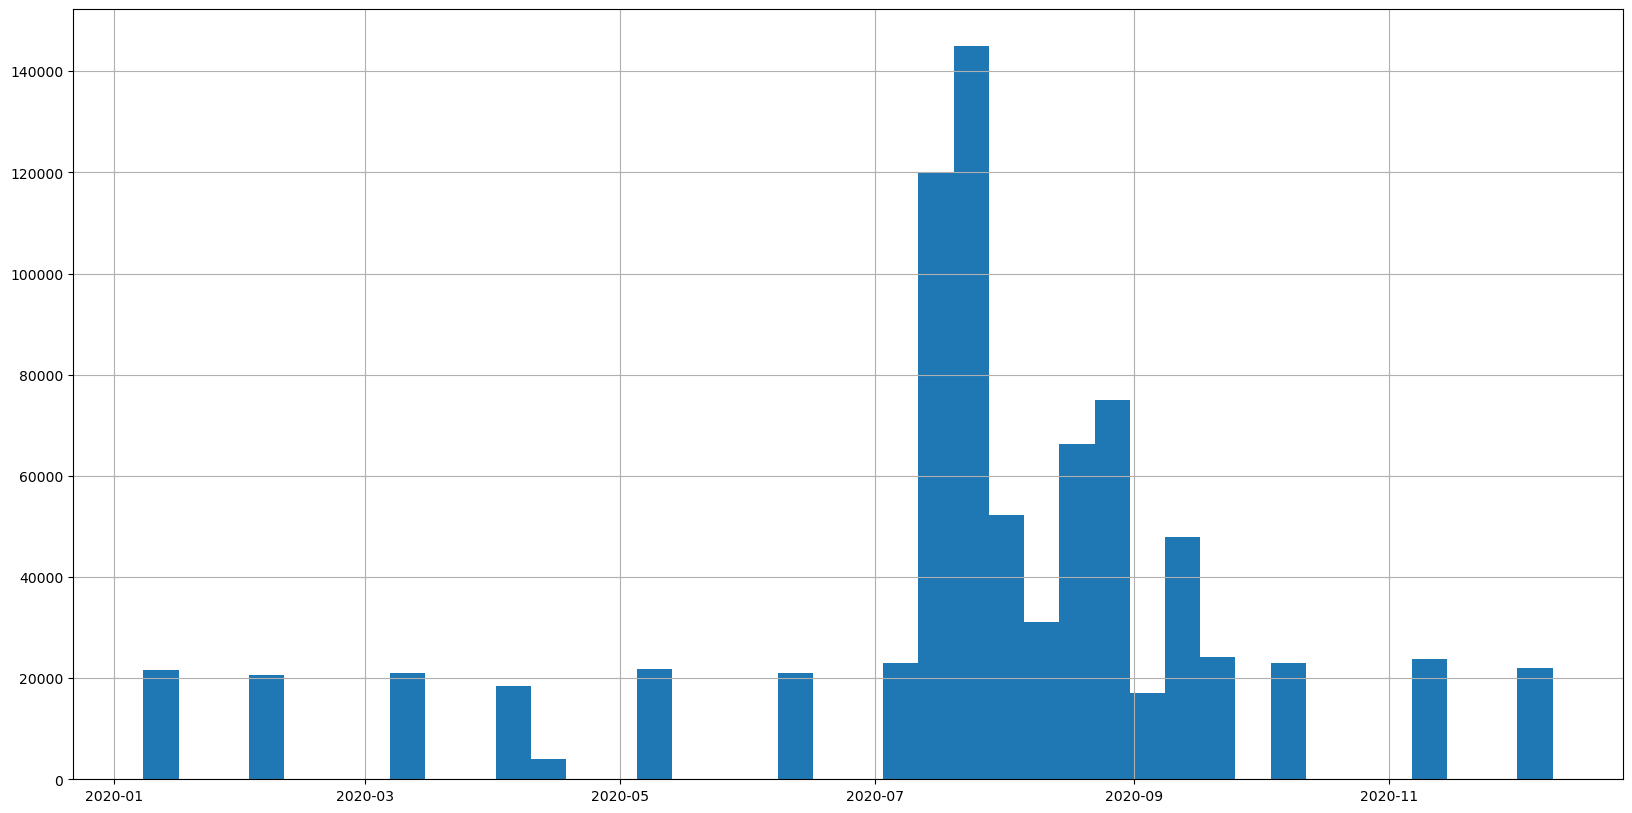

In [38]:
# check number of tweets over time

df["date"].hist(figsize=(20,10), bins=40)

In [39]:
# add moving average for plotting later
df["7day_rolling_avg"] = df["compound"].rolling(7).mean()

In [40]:
# add compound score to categorize into negative, neutral, and positive
df["comp_score"] = df["compound"].apply(lambda x: "pos" if x > 0 else ("neg" if x < 0 else "neu"))

In [41]:
df.head()

,date,text,neg,neu,pos,compound,year_month,7day_rolling_avg,comp_score
0,2020-09-07 11:34:00,This is a strange claim #LFC https://t.co/U1...,0.231,0.769,0.000,-0.2023,2020-09,NaN,neg
1,2020-09-07 11:33:00,RT @TheKopiteOFF: 😱| #LFC have won 30 of their...,0.143,0.640,0.217,0.4588,2020-09,NaN,pos
2,2020-09-07 11:33:00,RT @SkySportsPL: 🔴 - #LFC secure first away wi...,0.058,0.621,0.321,0.8793,2020-09,NaN,pos
3,2020-09-07 11:33:00,Outrageous... Poor auld Martin Tyler has to ju...,0.325,0.557,0.118,-0.6908,2020-09,NaN,neg
4,2020-09-07 11:33:00,RT @TheRedmenTV: ✅ Won the league ✅ Fastest te...,0.000,0.835,0.165,0.8176,2020-09,NaN,pos


In [42]:
df.corr()

,neg,neu,pos,compound,7day_rolling_avg
neg,1.000000,-0.414817,-0.115495,-0.520787,-0.243873
neu,-0.414817,1.000000,-0.855905,-0.443961,-0.217984
pos,-0.115495,-0.855905,1.000000,0.780628,0.376543
compound,-0.520787,-0.443961,0.780628,1.000000,0.463049
7day_rolling_avg,-0.243873,-0.217984,0.376543,0.463049,1.000000


<AxesSubplot:>

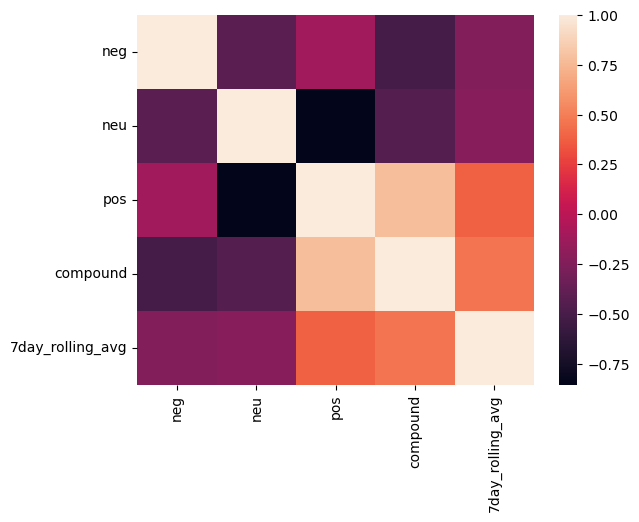

In [43]:
# check correlation
sns.heatmap(df.corr())

<AxesSubplot:>

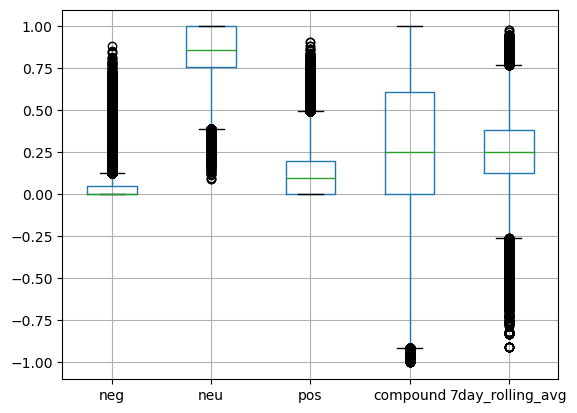

In [44]:
df.boxplot()

<AxesSubplot:ylabel='compound'>

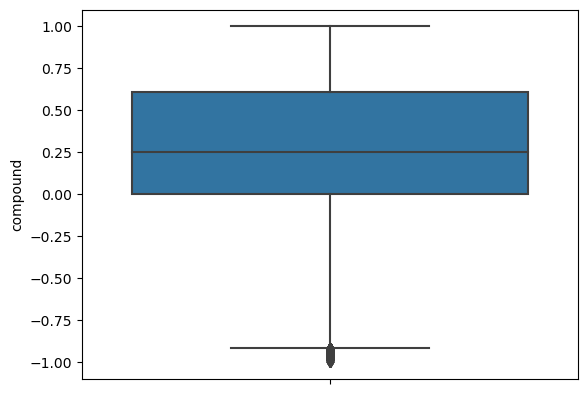

In [45]:
sns.boxplot(y=df["compound"])

<AxesSubplot:ylabel='compound'>

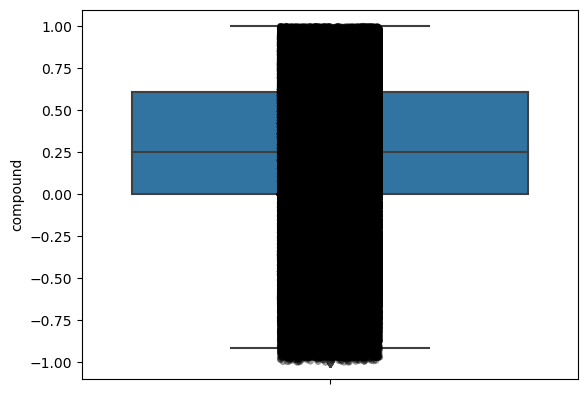

In [46]:
# check distribution of data points in compound columnn

sns.boxplot(y=df["compound"])
sns.stripplot(y=df["compound"], jitter=True, marker="o", alpha=0.4, color="black")

<AxesSubplot:>

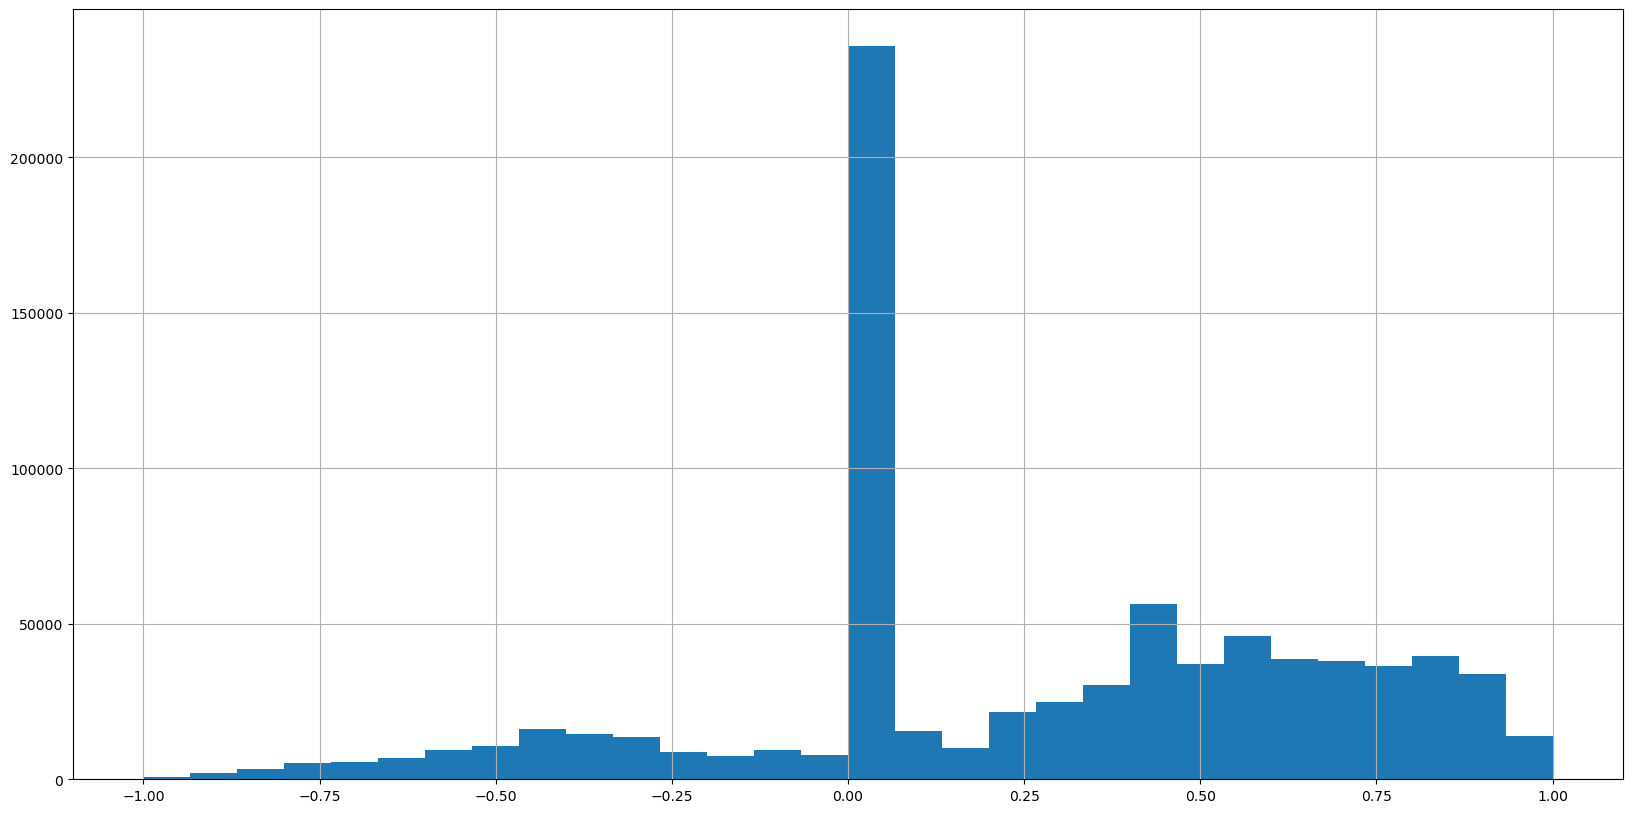

In [47]:
# check distribution of compound values from VADER
df["compound"].hist(bins=30, figsize=(20,10))

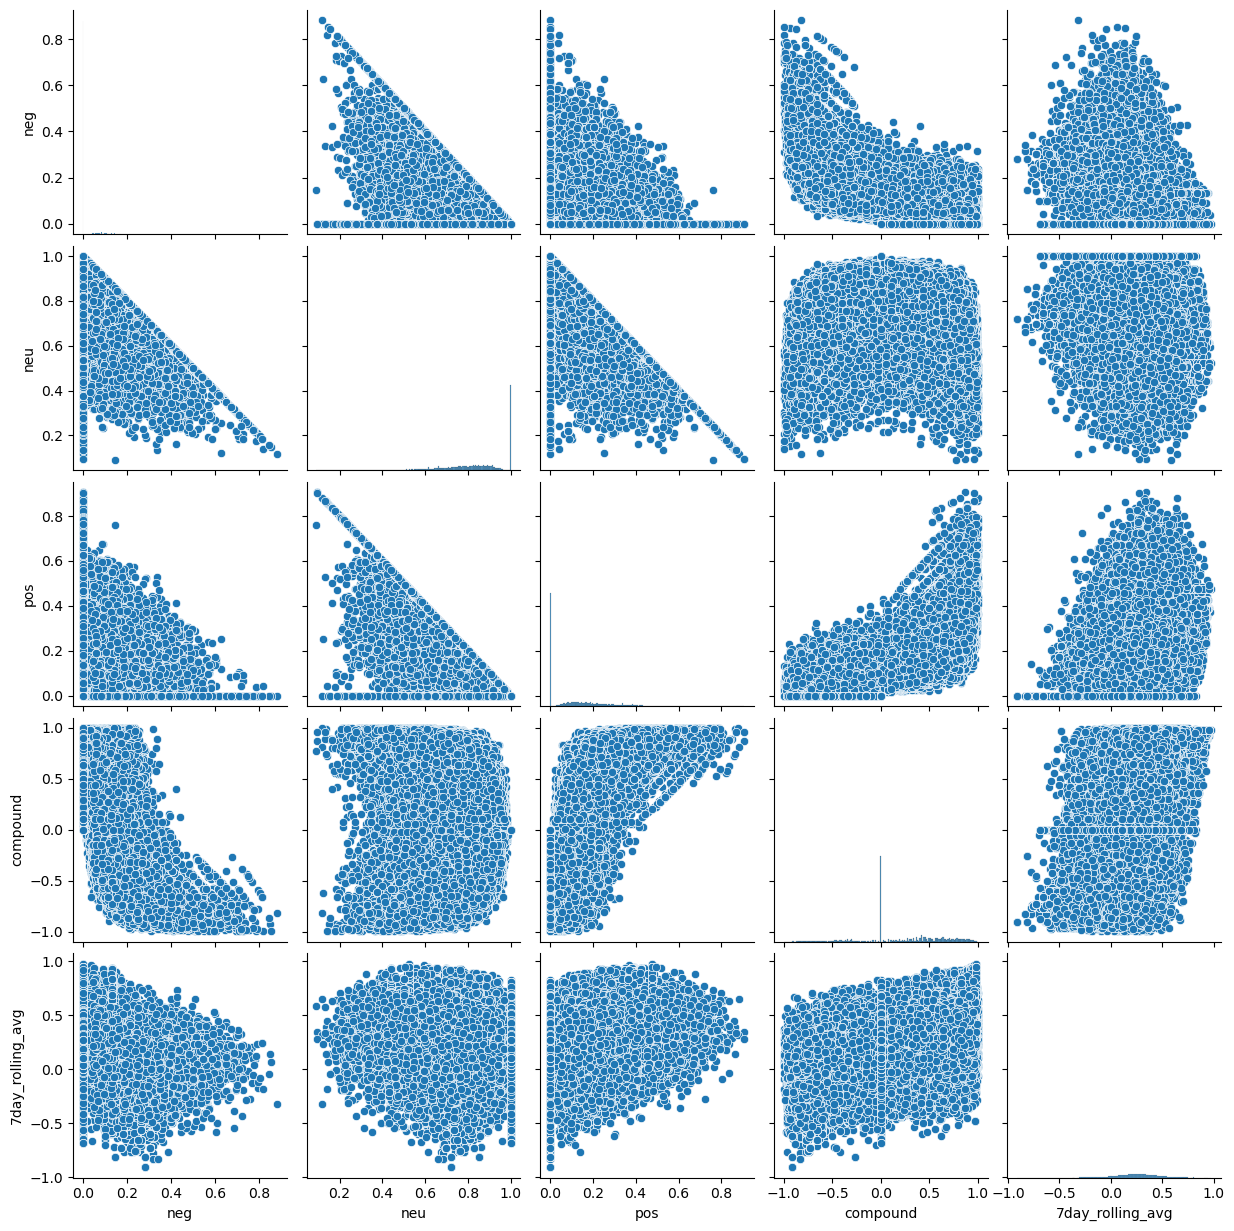

In [48]:
# perform pairplot analysis
sns.pairplot(df)

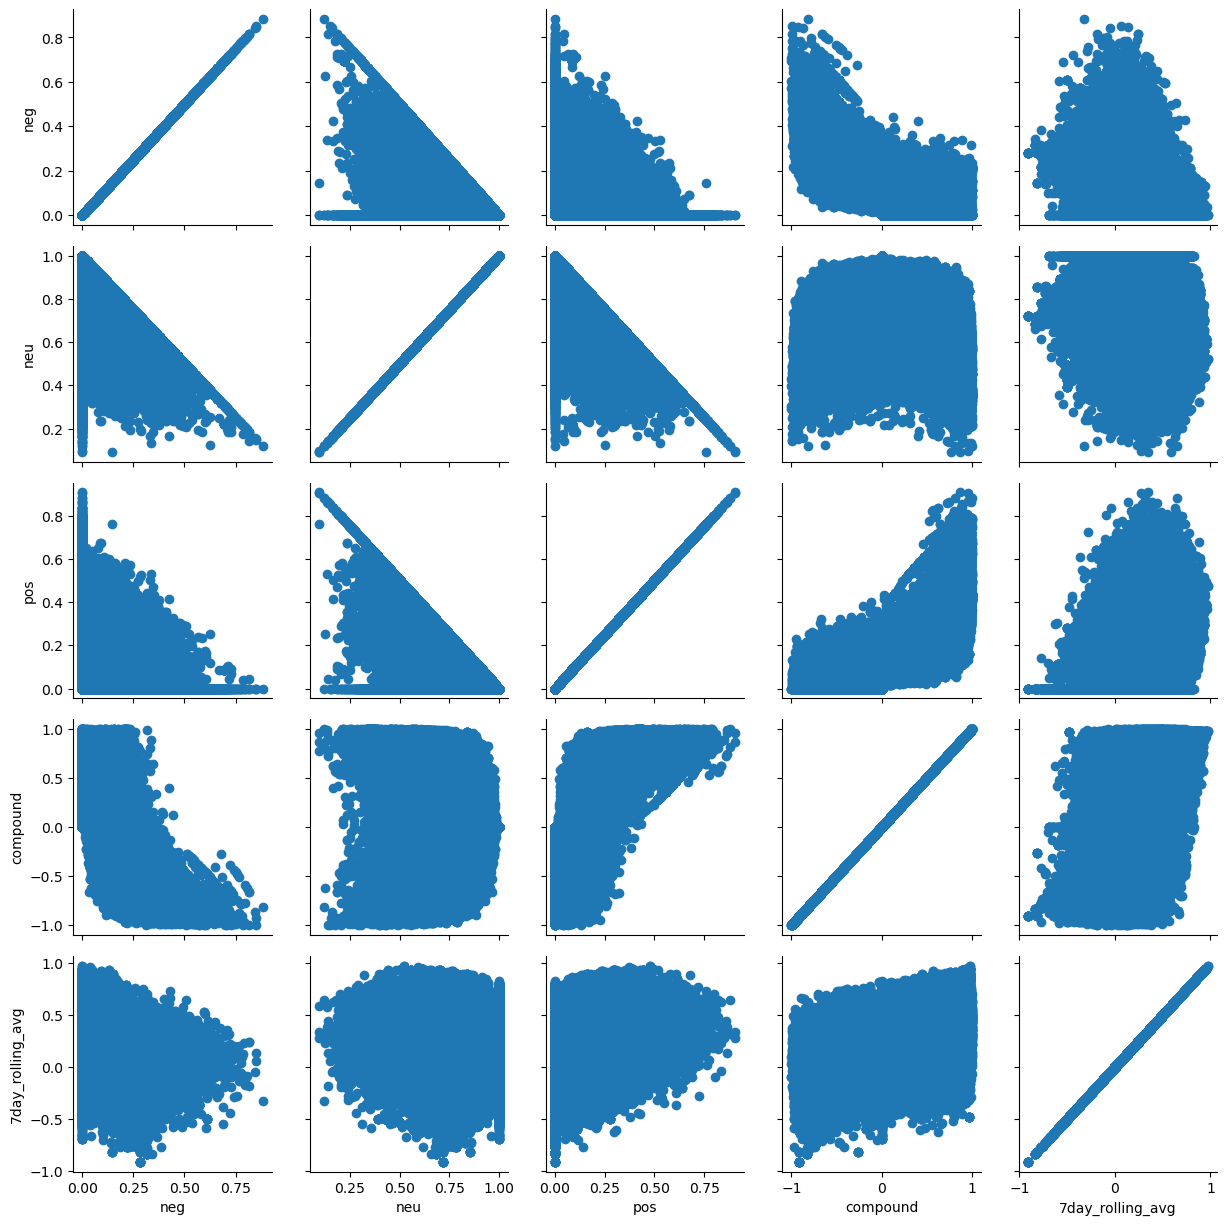

In [49]:
# check relationships and trends
g = sns.PairGrid(df)
g.map(plt.scatter)

# Conclusions and Visualizations

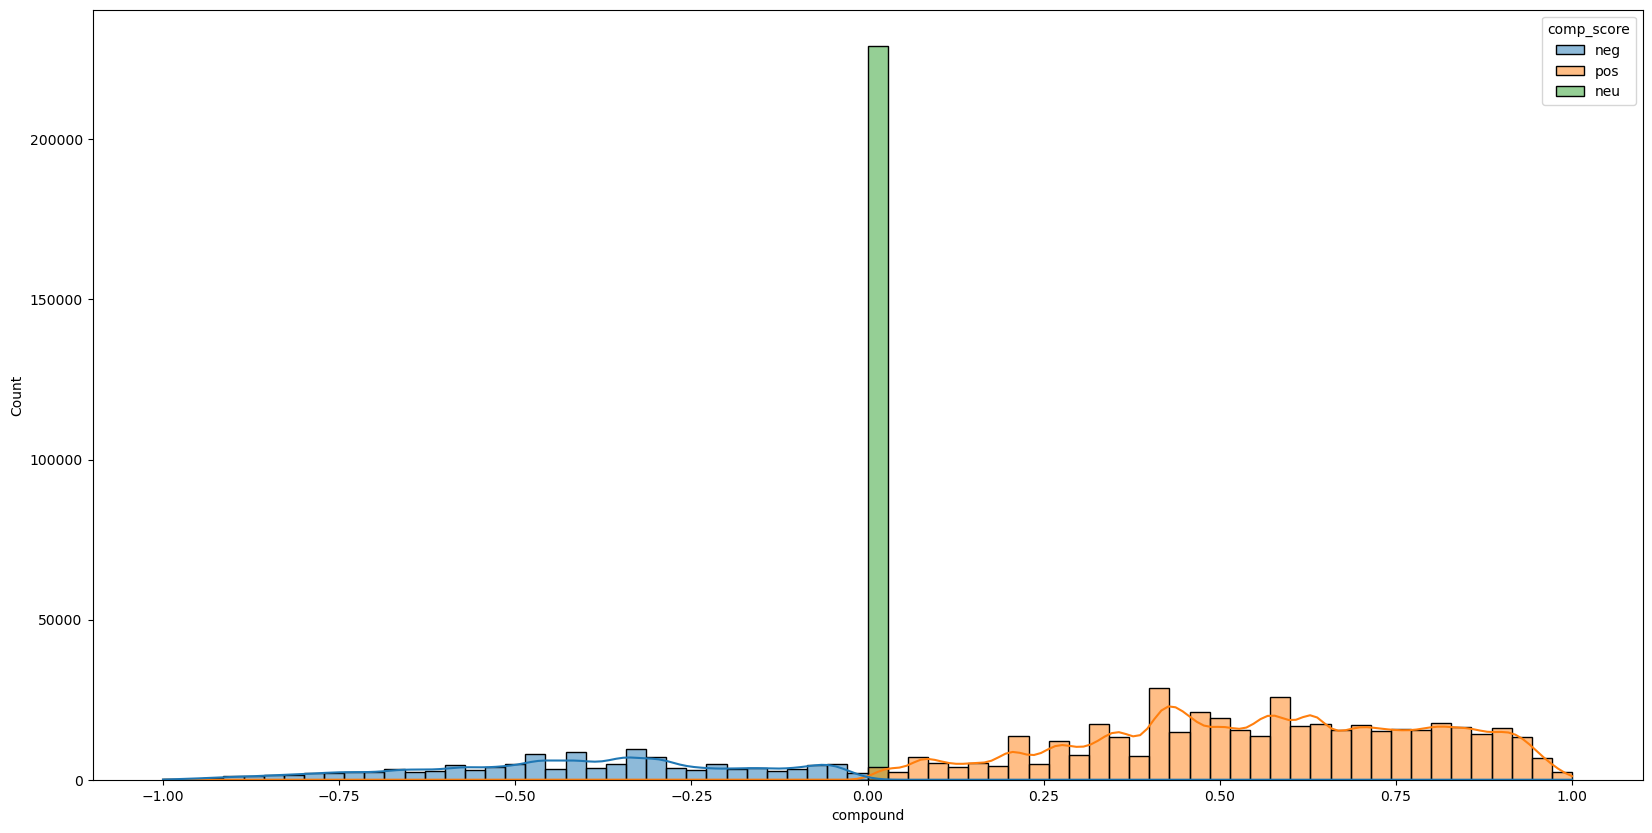

In [50]:
# generate histogram to show distribution of sentiment score
plt.figure(figsize=(20,10))
sns.histplot(data=df, x="compound", bins=70, kde=True, hue="comp_score")
plt.show()

The concentrated increase in sentiment scores, particularly within the neutral (0) to slightly positive (>0) range, suggests that the general public's perception leans towards a neutral to slightly positive sentiment.

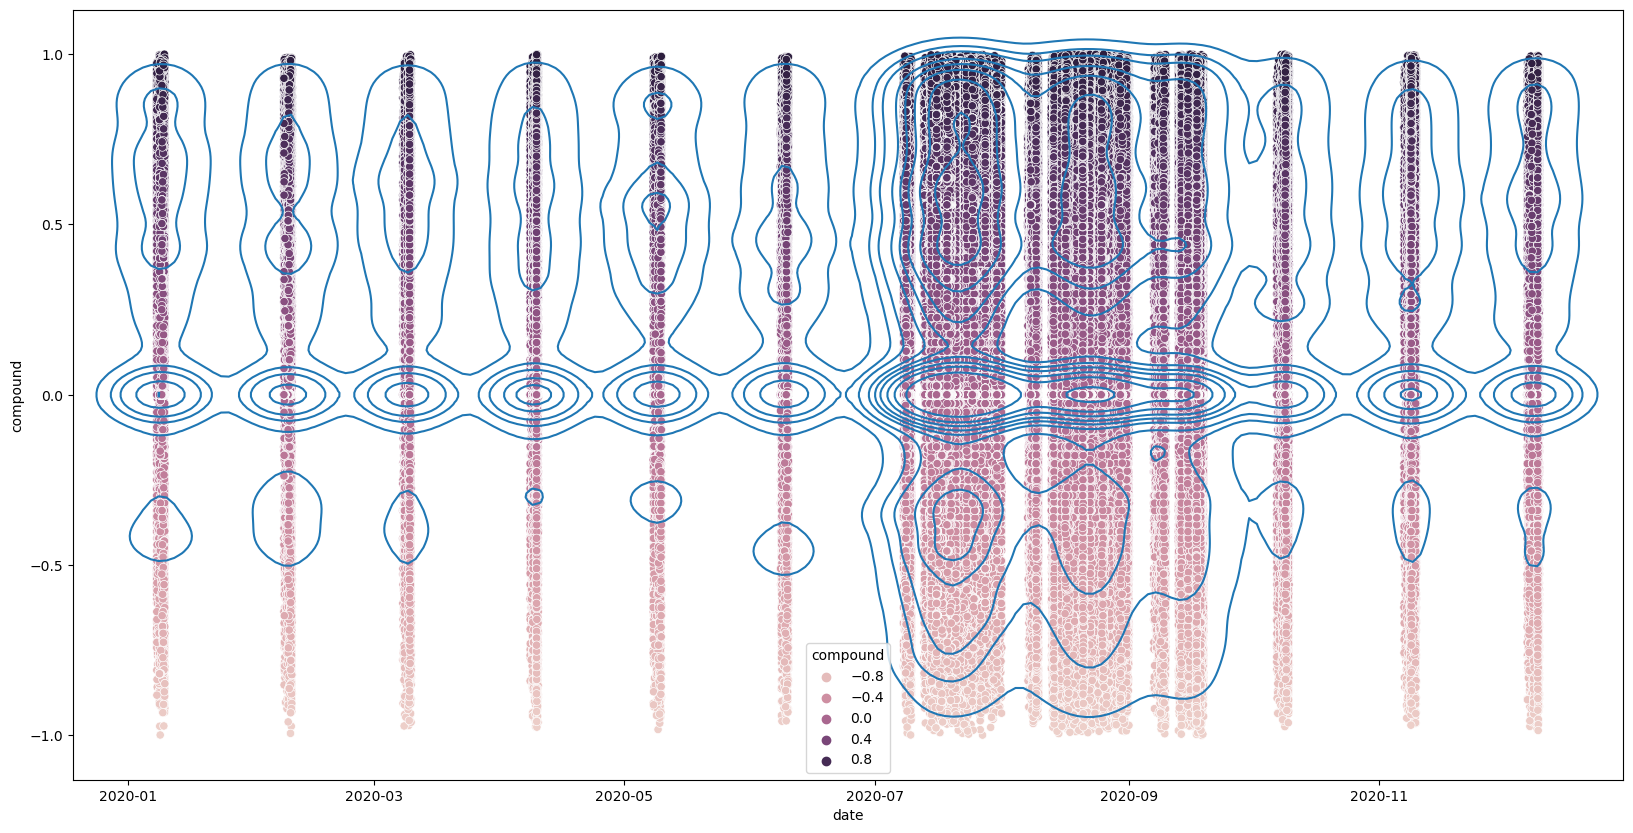

In [51]:
# generate scatterplot to show tweet's sentiment score over time
plt.figure(figsize=(20, 10))
sns.scatterplot(data=df, x="date", y="compound", hue="compound")
sns.kdeplot(x=df["date"], y=df["compound"])
plt.show()

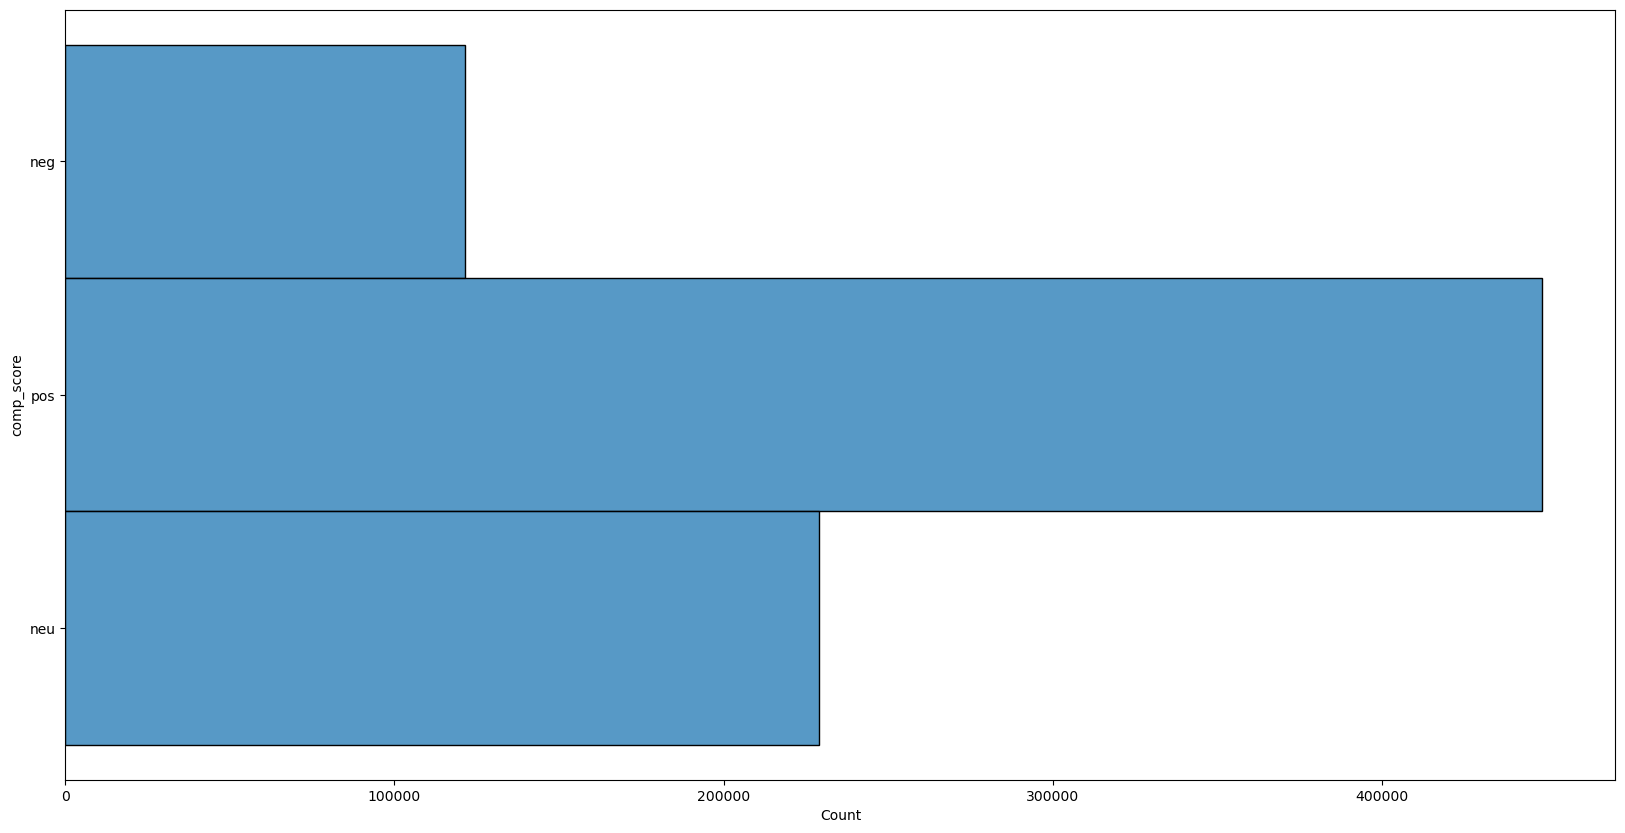

In [53]:
# show distribution of comp_score categories
plt.figure(figsize=(20,10))
sns.histplot(data=df, y="comp_score")
plt.show()

In [54]:
# calculate mean
df["compound"].mean()

0.25282711188135937

 The compound score is a metric used to measure the overall sentiment of a text, ranging from -1 (strongly negative) to 1 (strongly positive).The compound mean of 0.25282711188135937 suggests that, on average, people hold a positive sentiment towards the Premier League.

In [55]:
# split tweets into words for wordcloud
text = " ".join(t for t in df.text.astype(str))
print(f"There are {len(text)} words in the combination of all cells in column tweet.")

There are 115861835 words in the combination of all cells in column tweet.


In [60]:
# ignore stopwords that are frequently used
stopwords = set()
stopwords.update(["has","been","see","he","then","think","get","want","when","go","https", "co", "t", "gt", "i", "it", "a", "the", "but", "by", "my", "and", "in", "this", "all", "like", "will"
                 , "of", "as", "be", "is", "you", "their", "for", "so", "at", "just", "if", "me", "from", "now", "on", "to", "are"
                 , "what", "they", "an", "we", "here", "can", "with", "that", "have", "do"])

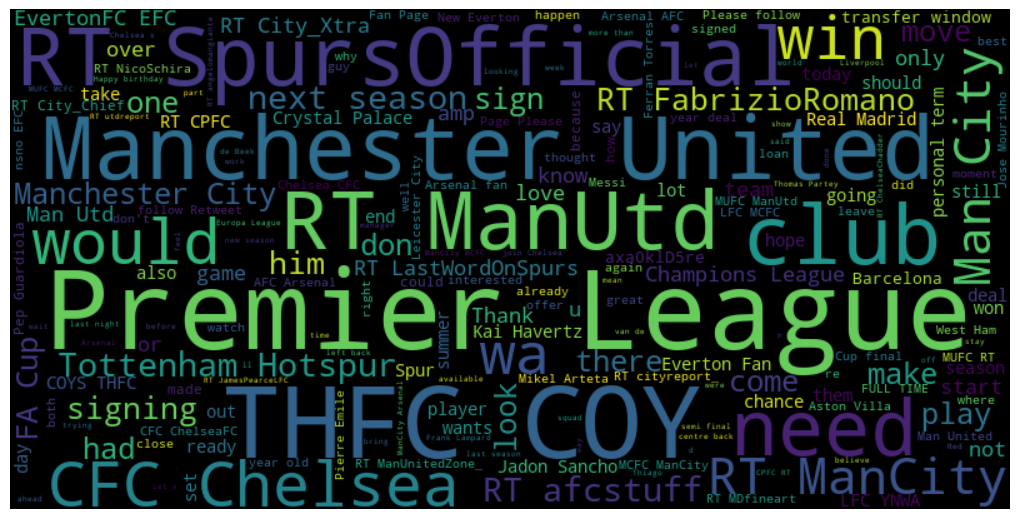

In [61]:
# create wordcloud object
wordcloud = WordCloud(stopwords=stopwords, background_color="black", width=800, height=400).generate(text)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.show()

Based on the above, it appears that Tottenham Hotspur and Manchester United are the most widely supported teams, closely followed by Chelsea and Manchester City. When it comes to individual players, Fabrizio Romano and Kai Havertz seem to dominate the discussions as the most talked-about players.

# Conclusion


Based on the popularity of teams and the predominantly positive sentiment expressed, it can be concluded that people generally hold a neutral to positive outlook on the English Premier League (EPL). The popularity of teams like Tottenham Hotspur, Manchester United, Chelsea, and Manchester City indicates a strong fan base and interest in the league. Additionally, the overall positive sentiment suggests that the general perception and attitude towards the EPL are favorable, emphasizing the league's appeal and positive reception among fans and followers.